# TARNet with MMD Penalty on Real Medical Imaging Data

This notebook implements:
1. Semi-synthetic approach using real chest X-ray images
2. Synthetic confounder generation (U)
3. Treatment assignment based on images and confounders
4. TARNet with Maximum Mean Discrepancy (MMD) penalty for balanced representations
5. Evaluation of PEHE vs confounding strength and hidden dimensions

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## 1. Data Loading and Preprocessing

In [12]:
class ChestXRayDataset(Dataset):
    """Dataset for loading chest X-ray images with generated confounders."""
    
    def __init__(self, data_dir, split='train', img_size=64, transform=None):
        self.data_dir = Path(data_dir) / split
        self.img_size = img_size
        self.transform = transform if transform else self._default_transform()
        
        # Load all image paths
        self.image_paths = []
        self.labels = []
        
        # Map categories to numeric labels
        self.category_map = {'NORMAL': 0, 'PNEUMONIA': 1, 'COVID19': 2}
        
        for category in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            category_dir = self.data_dir / category
            if category_dir.exists():
                for img_path in sorted(category_dir.glob('*.jpg')):
                    self.image_paths.append(img_path)
                    self.labels.append(self.category_map[category])
        
        print(f"Loaded {len(self.image_paths)} images from {split} set")
        print(f"Label distribution: {np.bincount(self.labels)}")
    
    def _default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        
        return image, label, str(img_path)

In [13]:
# Load datasets
data_dir = 'Data'
img_size = 64

train_dataset = ChestXRayDataset(data_dir, split='train', img_size=img_size)
test_dataset = ChestXRayDataset(data_dir, split='test', img_size=img_size)

print(f"\nTrain size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Loaded 5144 images from train set
Label distribution: [1266 3418  460]
Loaded 1288 images from test set
Label distribution: [317 855 116]

Train size: 5144
Test size: 1288


## 2. Semi-Synthetic Data Generation

Following the project specification:
- Use real medical images X
- Generate synthetic confounders U (unmeasured patient characteristics)
- Treatment assignment T depends on both X and U
- Outcomes depend on X, U, and T

In [14]:
def generate_semi_synthetic_data(dataset, confounder_dim=8, beta=1.0, seed=42):
    """
    Generate semi-synthetic causal inference data.
    
    Args:
        dataset: ChestXRayDataset object
        confounder_dim: Dimension of hidden confounder U
        beta: Confounding strength parameter
        seed: Random seed
    
    Returns:
        Dictionary with images, confounders, treatments, and outcomes
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    n = len(dataset)
    
    # Load all images and extract simple features
    images = []
    labels = []
    
    print("Loading images...")
    for i in tqdm(range(n)):
        img, label, _ = dataset[i]
        images.append(img)
        labels.append(label)
    
    images = torch.stack(images)
    labels = np.array(labels)
    
    # Generate hidden confounders U
    # U represents unmeasured patient characteristics
    U = np.random.randn(n, confounder_dim)
    
    # Extract simple image features for treatment/outcome generation
    # Use mean intensity and std as proxy for disease severity
    img_features = images.view(n, -1).numpy()
    img_mean = img_features.mean(axis=1, keepdims=True)
    img_std = img_features.std(axis=1, keepdims=True)
    X_simple = np.concatenate([img_mean, img_std, labels.reshape(-1, 1)], axis=1)
    
    # Standardize features
    X_simple = (X_simple - X_simple.mean(axis=0)) / (X_simple.std(axis=0) + 1e-8)
    
    # Generate treatment assignment based on X and U
    # T ~ Bernoulli(sigma(alpha^T X + beta^T U))
    alpha = np.random.randn(X_simple.shape[1])
    beta_vec = np.random.randn(confounder_dim)
    
    propensity_logit = X_simple @ alpha + beta * (U @ beta_vec)
    propensity = 1 / (1 + np.exp(-propensity_logit))
    T = np.random.binomial(1, propensity)
    
    print(f"Treatment distribution: {np.bincount(T)} (0={np.mean(T==0):.2%}, 1={np.mean(T==1):.2%})")
    
    # Generate potential outcomes Y0 and Y1
    # Y_t = f_t(X, U) + noise
    gamma_X = np.random.randn(X_simple.shape[1])
    gamma_U = np.random.randn(confounder_dim)
    
    # Base outcome depends on X and U
    base_outcome = X_simple @ gamma_X + U @ gamma_U
    
    # Treatment effects (heterogeneous based on confounders)
    treatment_effect_coef = np.random.randn(confounder_dim)
    treatment_effect = U @ treatment_effect_coef
    
    # Potential outcomes
    Y0 = base_outcome + np.random.randn(n) * 0.1
    Y1 = base_outcome + treatment_effect + np.random.randn(n) * 0.1
    
    # Observed outcome
    Y = T * Y1 + (1 - T) * Y0
    
    # True treatment effect
    tau_true = Y1 - Y0
    
    print(f"\nOutcome statistics:")
    print(f"  Y0 mean: {Y0.mean():.3f}, std: {Y0.std():.3f}")
    print(f"  Y1 mean: {Y1.mean():.3f}, std: {Y1.std():.3f}")
    print(f"  True ATE: {tau_true.mean():.3f}")
    print(f"  True PEHE: {np.std(tau_true):.3f}")
    
    return {
        'images': images,
        'U': U,
        'X_simple': X_simple,
        'T': T,
        'Y': Y,
        'Y0': Y0,
        'Y1': Y1,
        'tau_true': tau_true,
        'propensity': propensity,
        'labels': labels
    }

In [15]:
# Generate semi-synthetic data
confounder_dim = 8
beta = 1.0  # Confounding strength

print("Generating semi-synthetic training data...")
train_data = generate_semi_synthetic_data(
    train_dataset, 
    confounder_dim=confounder_dim, 
    beta=beta, 
    seed=42
)

print("\nGenerating semi-synthetic test data...")
test_data = generate_semi_synthetic_data(
    test_dataset, 
    confounder_dim=confounder_dim, 
    beta=beta, 
    seed=43
)

Generating semi-synthetic training data...
Loading images...


100%|██████████| 5144/5144 [02:09<00:00, 39.73it/s]


Treatment distribution: [2585 2559] (0=50.25%, 1=49.75%)

Outcome statistics:
  Y0 mean: -0.018, std: 1.970
  Y1 mean: -0.045, std: 2.780
  True ATE: -0.027
  True PEHE: 2.241

Generating semi-synthetic test data...
Loading images...


100%|██████████| 1288/1288 [00:33<00:00, 38.09it/s]

Treatment distribution: [683 605] (0=53.03%, 1=46.97%)

Outcome statistics:
  Y0 mean: -0.079, std: 2.963
  Y1 mean: -0.126, std: 4.397
  True ATE: -0.047
  True PEHE: 2.511


## 3. TARNet Architecture with MMD Penalty

TARNet consists of:
1. Shared CNN feature extractor Φ(X)
2. Separate outcome heads h0 and h1 for control and treatment

In [16]:
class CNNFeatureExtractor(nn.Module):
    """CNN feature extractor for chest X-ray images."""
    
    def __init__(self, input_channels=1, hidden_dims=[32, 64, 128], output_dim=128):
        super().__init__()
        
        layers = []
        in_channels = input_channels
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            ])
            in_channels = hidden_dim
        
        self.conv_layers = nn.Sequential(*layers)
        
        # Calculate the size after convolutions
        # For img_size=64 with 3 maxpool layers: 64 -> 32 -> 16 -> 8
        self.flatten_dim = hidden_dims[-1] * (64 // (2 ** len(hidden_dims))) ** 2
        
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, output_dim),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class OutcomeHead(nn.Module):
    """MLP head for outcome prediction."""
    
    def __init__(self, input_dim, hidden_dims=[100, 50]):
        super().__init__()
        
        layers = []
        in_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            in_dim = hidden_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze(-1)


class TARNet(nn.Module):
    """Treatment-Agnostic Representation Network."""
    
    def __init__(self, representation_dim=128, head_hidden_dims=[100, 50]):
        super().__init__()
        
        self.feature_extractor = CNNFeatureExtractor(output_dim=representation_dim)
        self.h0 = OutcomeHead(representation_dim, head_hidden_dims)  # Control head
        self.h1 = OutcomeHead(representation_dim, head_hidden_dims)  # Treatment head
    
    def forward(self, x, t=None):
        """
        Args:
            x: Input images
            t: Treatment indicators (optional)
        
        Returns:
            If t is provided: predicted outcome for given treatment
            If t is None: (Y0_pred, Y1_pred, representation)
        """
        phi = self.feature_extractor(x)
        y0_pred = self.h0(phi)
        y1_pred = self.h1(phi)
        
        if t is not None:
            # Return outcome for observed treatment
            y_pred = t * y1_pred + (1 - t) * y0_pred
            return y_pred, phi
        else:
            # Return both potential outcomes and representation
            return y0_pred, y1_pred, phi
    
    def predict_ite(self, x):
        """Predict individual treatment effect."""
        y0_pred, y1_pred, _ = self.forward(x, t=None)
        return y1_pred - y0_pred

## 4. MMD (Maximum Mean Discrepancy) Loss

In [17]:
def compute_mmd(x, y, kernel='rbf', gamma=1.0):
    """
    Compute Maximum Mean Discrepancy between two samples.
    
    Args:
        x: First sample (n_x, d)
        y: Second sample (n_y, d)
        kernel: Kernel type ('rbf' or 'linear')
        gamma: RBF kernel bandwidth parameter
    
    Returns:
        MMD distance
    """
    if kernel == 'linear':
        # Linear MMD
        mean_x = x.mean(dim=0)
        mean_y = y.mean(dim=0)
        return torch.sum((mean_x - mean_y) ** 2)
    
    elif kernel == 'rbf':
        # RBF kernel MMD
        xx = torch.mm(x, x.t())
        yy = torch.mm(y, y.t())
        xy = torch.mm(x, y.t())
        
        x_sqnorms = torch.diag(xx)
        y_sqnorms = torch.diag(yy)
        
        def kernel_matrix(sqnorms_a, sqnorms_b, cross_term):
            return torch.exp(-gamma * (
                sqnorms_a.unsqueeze(1) + sqnorms_b.unsqueeze(0) - 2 * cross_term
            ))
        
        K_xx = kernel_matrix(x_sqnorms, x_sqnorms, xx)
        K_yy = kernel_matrix(y_sqnorms, y_sqnorms, yy)
        K_xy = kernel_matrix(x_sqnorms, y_sqnorms, xy)
        
        n_x = x.size(0)
        n_y = y.size(0)
        
        mmd = (K_xx.sum() - K_xx.trace()) / (n_x * (n_x - 1))
        mmd += (K_yy.sum() - K_yy.trace()) / (n_y * (n_y - 1))
        mmd -= 2 * K_xy.mean()
        
        return mmd
    
    else:
        raise ValueError(f"Unknown kernel: {kernel}")

## 5. Training Function with MMD Penalty

In [18]:
def train_tarnet(model, train_data, val_data, 
                 alpha=0.0, mmd_kernel='linear', mmd_gamma=1.0,
                 epochs=100, batch_size=64, lr=1e-3, 
                 device='cuda', early_stopping_patience=10):
    """
    Train TARNet with optional MMD penalty.
    
    Args:
        model: TARNet model
        train_data: Training data dictionary
        val_data: Validation data dictionary
        alpha: MMD penalty weight (0 = vanilla TARNet)
        mmd_kernel: MMD kernel type
        mmd_gamma: RBF kernel parameter
        epochs: Number of training epochs
        batch_size: Batch size
        lr: Learning rate
        device: Device to train on
        early_stopping_patience: Patience for early stopping
    
    Returns:
        Training history
    """
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Prepare data
    X_train = train_data['images'].to(device)
    T_train = torch.tensor(train_data['T'], dtype=torch.float32).to(device)
    Y_train = torch.tensor(train_data['Y'], dtype=torch.float32).to(device)
    
    X_val = val_data['images'].to(device)
    T_val = torch.tensor(val_data['T'], dtype=torch.float32).to(device)
    Y_val = torch.tensor(val_data['Y'], dtype=torch.float32).to(device)
    
    n_train = len(X_train)
    
    history = {
        'train_loss': [],
        'train_mse': [],
        'train_mmd': [],
        'val_loss': [],
        'val_pehe': [],
        'val_ate_error': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        
        # Shuffle data
        perm = torch.randperm(n_train)
        
        epoch_losses = []
        epoch_mse = []
        epoch_mmd = []
        
        for i in range(0, n_train, batch_size):
            idx = perm[i:i+batch_size]
            
            x_batch = X_train[idx]
            t_batch = T_train[idx]
            y_batch = Y_train[idx]
            
            optimizer.zero_grad()
            
            # Forward pass
            y_pred, phi = model(x_batch, t_batch)
            
            # MSE loss (factual loss)
            mse_loss = F.mse_loss(y_pred, y_batch)
            
            # MMD penalty for balanced representations
            mmd_loss = torch.tensor(0.0, device=device)
            if alpha > 0:
                # Separate representations by treatment group
                phi_treated = phi[t_batch == 1]
                phi_control = phi[t_batch == 0]
                
                if len(phi_treated) > 1 and len(phi_control) > 1:
                    mmd_loss = compute_mmd(
                        phi_treated, phi_control, 
                        kernel=mmd_kernel, gamma=mmd_gamma
                    )
            
            # Total loss
            loss = mse_loss + alpha * mmd_loss
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_losses.append(loss.item())
            epoch_mse.append(mse_loss.item())
            epoch_mmd.append(mmd_loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred, _ = model(X_val, T_val)
            val_mse = F.mse_loss(y_val_pred, Y_val).item()
            
            # Compute PEHE on validation set
            tau_pred = model.predict_ite(X_val).cpu().numpy()
            tau_true = val_data['tau_true']
            pehe = np.sqrt(np.mean((tau_pred - tau_true) ** 2))
            ate_error = np.abs(tau_pred.mean() - tau_true.mean())
        
        # Update history
        history['train_loss'].append(np.mean(epoch_losses))
        history['train_mse'].append(np.mean(epoch_mse))
        history['train_mmd'].append(np.mean(epoch_mmd))
        history['val_loss'].append(val_mse)
        history['val_pehe'].append(pehe)
        history['val_ate_error'].append(ate_error)
        
        # Learning rate scheduling
        scheduler.step(val_mse)
        
        # Early stopping
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | "
                  f"Loss: {history['train_loss'][-1]:.4f} | "
                  f"MSE: {history['train_mse'][-1]:.4f} | "
                  f"MMD: {history['train_mmd'][-1]:.4f} | "
                  f"Val Loss: {val_mse:.4f} | "
                  f"PEHE: {pehe:.4f} | "
                  f"ATE Error: {ate_error:.4f}")
        
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping at epoch {epoch}")
            break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

## 6. Evaluation Metrics

In [19]:
def evaluate_model(model, test_data, device='cuda'):
    """
    Evaluate model on test data.
    
    Returns:
        Dictionary with PEHE and ATE error
    """
    model.eval()
    
    X_test = test_data['images'].to(device)
    
    with torch.no_grad():
        tau_pred = model.predict_ite(X_test).cpu().numpy()
    
    tau_true = test_data['tau_true']
    
    # PEHE: sqrt(E[(tau_pred - tau_true)^2])
    pehe = np.sqrt(np.mean((tau_pred - tau_true) ** 2))
    
    # ATE error: |E[tau_pred] - E[tau_true]|
    ate_pred = tau_pred.mean()
    ate_true = tau_true.mean()
    ate_error = np.abs(ate_pred - ate_true)
    
    return {
        'pehe': pehe,
        'ate_error': ate_error,
        'ate_pred': ate_pred,
        'ate_true': ate_true,
        'tau_pred': tau_pred,
        'tau_true': tau_true
    }

## 7. Experiment 1: Effect of MMD Penalty (α)

In [20]:
# Test different MMD penalty weights
alphas = [0.0, 0.01, 0.1, 0.5, 1.0, 2.0]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

results_alpha = []

for alpha in alphas:
    print(f"\n{'='*60}")
    print(f"Training with alpha = {alpha}")
    print(f"{'='*60}")
    
    # Initialize model
    model = TARNet(representation_dim=128, head_hidden_dims=[100, 50])
    
    # Train
    history = train_tarnet(
        model, train_data, test_data,
        alpha=alpha,
        mmd_kernel='linear',
        epochs=100,
        batch_size=64,
        lr=1e-3,
        device=device,
        early_stopping_patience=15
    )
    
    # Evaluate
    eval_results = evaluate_model(model, test_data, device=device)
    
    results_alpha.append({
        'alpha': alpha,
        'pehe': eval_results['pehe'],
        'ate_error': eval_results['ate_error'],
        'history': history
    })
    
    print(f"\nTest PEHE: {eval_results['pehe']:.4f}")
    print(f"Test ATE Error: {eval_results['ate_error']:.4f}")

Using device: cpu

Training with alpha = 0.0
Epoch   0 | Loss: 5.3147 | MSE: 5.3147 | MMD: 0.0000 | Val Loss: 15.1165 | PEHE: 2.7228 | ATE Error: 0.7982
Epoch  10 | Loss: 4.8308 | MSE: 4.8308 | MMD: 0.0000 | Val Loss: 15.8970 | PEHE: 2.5453 | ATE Error: 0.3875

Early stopping at epoch 16

Test PEHE: 2.5749
Test ATE Error: 0.5102

Training with alpha = 0.01
Epoch   0 | Loss: 5.5494 | MSE: 5.4271 | MMD: 12.2263 | Val Loss: 14.1625 | PEHE: 2.6273 | ATE Error: 0.7489
Epoch  10 | Loss: 4.9182 | MSE: 4.8911 | MMD: 2.7091 | Val Loss: 15.8874 | PEHE: 2.5539 | ATE Error: 0.4294

Early stopping at epoch 15

Test PEHE: 2.5703
Test ATE Error: 0.5173

Training with alpha = 0.1
Epoch   0 | Loss: 5.8477 | MSE: 5.5889 | MMD: 2.5879 | Val Loss: 14.1223 | PEHE: 2.6231 | ATE Error: 0.7551
Epoch  10 | Loss: 5.5404 | MSE: 5.5404 | MMD: 0.0000 | Val Loss: 13.7025 | PEHE: 2.6946 | ATE Error: 0.9786

Early stopping at epoch 19

Test PEHE: 2.6443
Test ATE Error: 0.8300

Training with alpha = 0.5
Epoch   0 | Lo

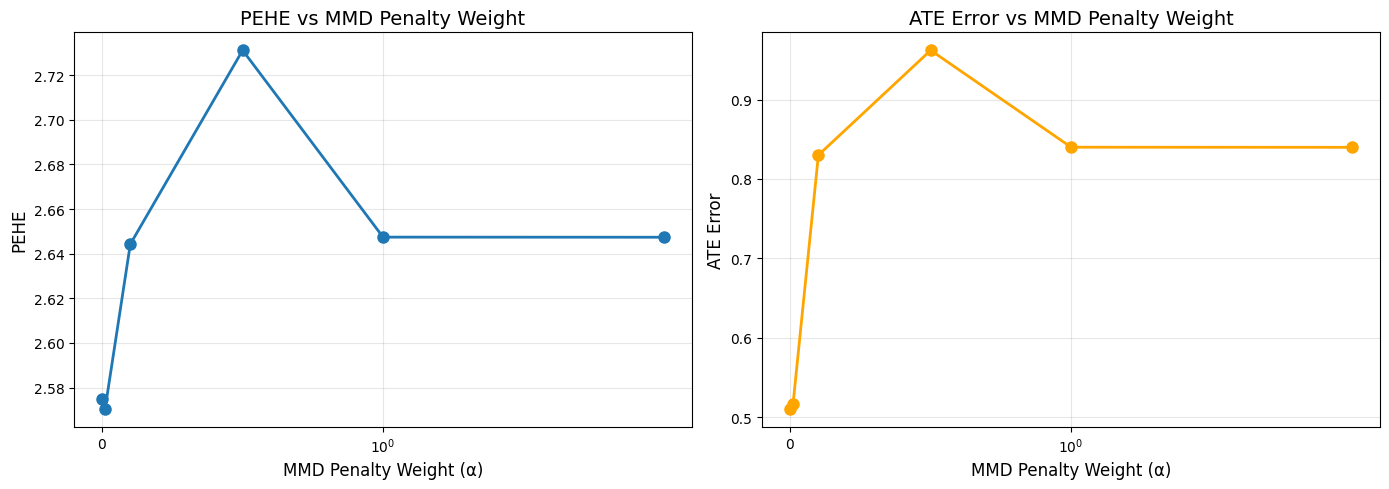


Results Summary:
α =  0.00 | PEHE = 2.5749 | ATE Error = 0.5102
α =  0.01 | PEHE = 2.5703 | ATE Error = 0.5173
α =  0.10 | PEHE = 2.6443 | ATE Error = 0.8300
α =  0.50 | PEHE = 2.7311 | ATE Error = 0.9620
α =  1.00 | PEHE = 2.6474 | ATE Error = 0.8400
α =  2.00 | PEHE = 2.6474 | ATE Error = 0.8398


In [21]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas_plot = [r['alpha'] for r in results_alpha]
pehe_plot = [r['pehe'] for r in results_alpha]
ate_plot = [r['ate_error'] for r in results_alpha]

axes[0].plot(alphas_plot, pehe_plot, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('MMD Penalty Weight (α)', fontsize=12)
axes[0].set_ylabel('PEHE', fontsize=12)
axes[0].set_title('PEHE vs MMD Penalty Weight', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('symlog')

axes[1].plot(alphas_plot, ate_plot, 'o-', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('MMD Penalty Weight (α)', fontsize=12)
axes[1].set_ylabel('ATE Error', fontsize=12)
axes[1].set_title('ATE Error vs MMD Penalty Weight', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('symlog')

plt.tight_layout()
plt.savefig('pehe_vs_alpha_real_data.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nResults Summary:")
for r in results_alpha:
    print(f"α = {r['alpha']:5.2f} | PEHE = {r['pehe']:.4f} | ATE Error = {r['ate_error']:.4f}")